## Spaceship Titanic CRISP-DM

This notebook addressses ...

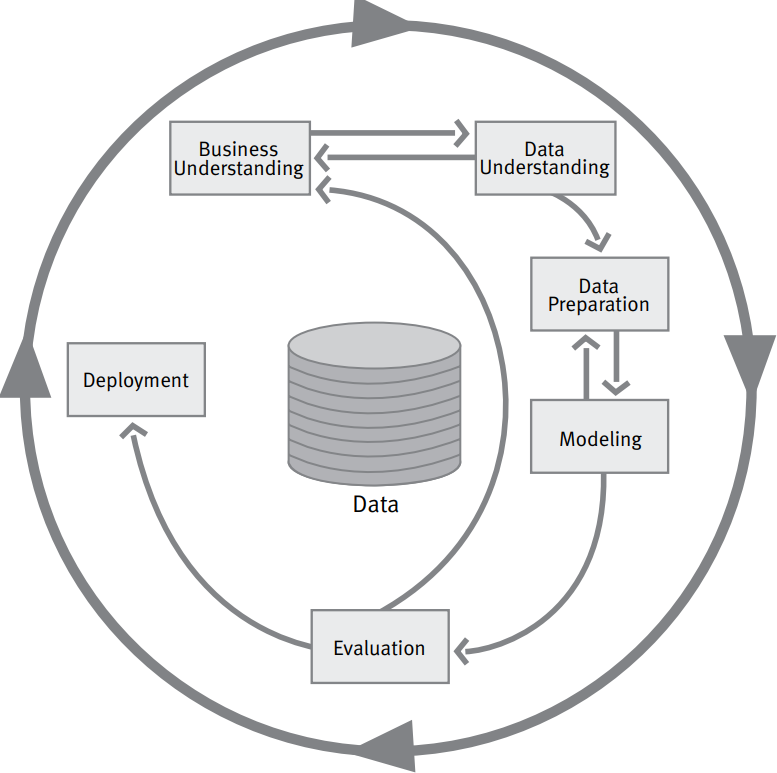

Resources:
- [Quick CRISP-DM explainer](https://www.datascience-pm.com/crisp-dm-2/)
- [Full guide](https://web.archive.org/web/20220401041957/https://www.the-modeling-agency.com/crisp-dm.pdf)


### Business Understanding
Understanding the objectives an requirements of the project
1. Determine business objectives: What does the customer really want?
2. Assess situation: available resources, project requirements, risks & contingencies, and conduct a cost-benefit analysis
3. Determine data mining goals: in addition to defining business objectives, what does success look like from a techincal perspective?
4. Produce project plan: Select technologies and tools and define detailed plans for each project phase

**Spaceship Titanic Scenario**
1. Business objective
    - From Kaggle: *"To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system"*
    - Given the available training data set, predict which passengers were transported
2. Assess situation
    - Resources: more information on the Kaggle page
    - Project requirements: Max 4 hours of time to finish the final prediction (set by myself)
3. Data mining goals: in this case the data mining goal is very similar to business objective
4. Project plan
    1. Describe the data: number of records, feature description, feature dtypes
    2. Create a baseline:
        1. Select few techniques to predict `transported` feature: logitic regression, svm, random forest
        2. Naively prepare the data to create a baseline: dropping NaN entries, no further imputing, scale the data, no new feature engineering
        3. Naively predict using the data and selected models: no futher finetuning of the parameters
    3. Try to improve the model within 4 hours:
        1. Find relationships between the features
        2. Assess data quality, e.g. missing data/invalid data
        3. Prioritize efforts for data imputing, feature selection, feature engineering and select what steps to include
        4. Predict using new data set and explore quick parameter finetuning (gridsearch?)

### Data Understanding
1. Collect data
2. Describe the data: document the surface properties of the data like: feature types, dtypes, number of records
3. Explore the data: dig deeper into the data, visualize relationships
4. Verify the data quality: is there invalid/missing data?

**Spaceship Titanic Scenario**
As written in the process plan above, we're first setting a baseline and therefore only collecting and describing the data. After the baseline is set, we'll move on with further data exploration